# Neural Image Caption Generation with Visual Attention

The purpose of this project is to build an image captioning predictor. Given an image, the algorithm should predict what is the appropriate caption correspond to the picture. This project follows the step-by-step method from TensorFlow tutorial on image captioning. You can find the corresponding tutorial by TensorFlow [here](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb#scrollTo=Dx_fvbVgRPGQ).

To do this, the concept of encoder-decoder will be applied. Convolutional Neural Networks is applied as the encoder, while Recurrent Neural Networks is applied as the decoder.

The dataset used for this project was taken from MS COCO 2017 dataset, which contains hundreds of thousand of images with their corresponding captions. To speed up the training process, only 20000 images will be used as training and validation set.

Now let's import all the necessary libraries

In [2]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import time
from PIL import Image

## Preprocess the Data

The first thing that needs to be done is to set the path to the training images as well as the training annotations.

In [4]:
annotation_file = os.path.join('D:/Image Captioning/annotations/captions_train2014.json')
img_dir = os.path.join('D:/Image Captioning/train2014/')

Next, let's read the json file contains the annotations for each of the training images.

In [5]:
with open(annotation_file, 'r') as f:
    
    annotations = json.load(f)

Take a look at what the annotations look like after we read the json file

In [5]:
annotations['annotations'][0:5]

[{'image_id': 318556,
  'id': 48,
  'caption': 'A very clean and well decorated empty bathroom'},
 {'image_id': 116100,
  'id': 67,
  'caption': 'A panoramic view of a kitchen and all of its appliances.'},
 {'image_id': 318556,
  'id': 126,
  'caption': 'A blue and white bathroom with butterfly themed wall tiles.'},
 {'image_id': 116100,
  'id': 148,
  'caption': 'A panoramic photo of a kitchen and dining room'},
 {'image_id': 379340,
  'id': 173,
  'caption': 'A graffiti-ed stop sign across the street from a red car '}]

In order to make it clearer about what the image data and its caption looks like, we need to arrange them into different variables with the same length: `caption` and `img_name`, but the specific index in the `caption` variable corresponds to the same index in `img_name` variables.

In [6]:
captions = []
img_name = []

for annot in annotations['annotations']:
    
    caption = '<start> '+ annot['caption'] +' <end>'
    img_id = annot['image_id']
    coco_img = img_dir + 'COCO_train2014_'+ '%012d.jpg' % (img_id)
    
    captions.append(caption)
    img_name.append(coco_img)

Now let's visualize a random image and its corresponding caption.

Caption: <start> A panoramic view of a kitchen and all of its appliances. <end>


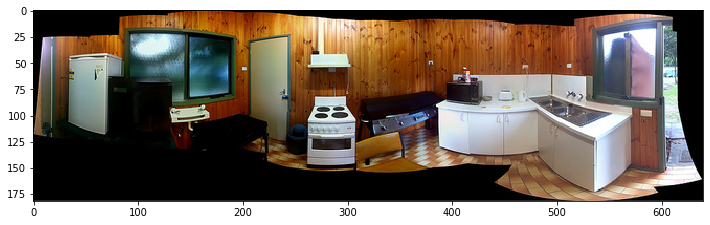

In [7]:
img = mpimg.imread(img_name[1])
plt.figure(figsize=(12,6))
plt.imshow(img)
print('Caption: '+ captions[1])

As we can see above, there is a random image of what supposed to be a kitchen and the corresponding caption for this image. The next step would be randomly picked a fixed number of images from the entire MS COCO dataset. As mentioned in the introduction, out of hundreds of images in MS COCO dataset, we are going to use only 20000 of them and the images are going to be picked randomly to speed up the training process.  

In [8]:
train_captions, img_name_vector = shuffle(captions,
                                          img_name,
                                          random_state=1)


num_examples = 20000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

As the model to preprocess the image, we are going to use a pretrained model with Inception V3 architecture. The weights that are going to be used are coming from ImageNet.

In [10]:
model = InceptionV3(include_top=False, weights='imagenet')

img_model = Model(model.input, model.layers[-1].output)

## Caching the Feature Vectors of Images

We created the model and the corresponding pretrained weights using Inception V3 architecture already, now we want to preprocess the image using this model. For each image, the output vectors will be stored in the local disk for caching purpose.

In [12]:

encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = img_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

1136it [39:49,  2.10s/it]


## Tokenizing Captions

Now after preprocess the image, next we move on to preprocess the captions of each image.

The first thing that we should do to preprocess the caption is to create a corpus of words containing the caption of all of the training images.

Next, we need to convert the words in every captions into their index representation, which means that we'll end up with sequence of word indexes instead of words. Finally, we pad every captions such that they all have the same sequence length.

In [13]:
vocab_size = 5000

tokenizer = Tokenizer(num_words = vocab_size, oov_token = '<oov>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_sequences = tokenizer.texts_to_sequences(train_captions)
cap_vector = pad_sequences(train_sequences, padding='post')


print(train_sequences[5])
print(train_captions[5])

[3, 1871, 6, 17, 18, 113, 7, 91, 109, 4]
<start> groups of people standing around the toilet area <end>


In [14]:
def calc_max_seq_length(sequence):
    return max(len(t) for t in sequence)

max_length = calc_max_seq_length(train_sequences)
max_length

49

## Split Train Test Set

Now after we preprocess the image into feature vectors and the captions into sequence of word indexes, next we can start to split the feature vector of images and their corresponding word indexes of caption into training set and validation set using the sklearn libray.

In [46]:
img_name_train, img_name_val, caption_train, caption_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)


In [16]:
len(img_name_train), len(caption_train), len(img_name_val), len(caption_val)

(16000, 16000, 4000, 4000)

## Model

The next step would be to build the model that consists of encoder and decoder. The encoder consists of Fully conected layers and the decoder consists of Embedding Layers and Recurrent Layers such as GRU. As the visual attention, the model from Bahdanau et. in 2014 will be applied.

In [17]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = vocab_size + 1
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape

features_shape = 2048
attention_features_shape = 64

In [18]:
class BahdanauAttention(tf.keras.Model):
    
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [19]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [20]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [21]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Model Checkpoint

Next, let's create a model checkpoint to save all of the trained variables.

In [55]:
checkpoint_path = "C:/Users/ASUS/ImageCaption/checkpoint/."
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [56]:
loss_plot = []
start_epoch = 0

## Train the Model

In [57]:
@tf.function
def train_step(img_tensor, target):
    
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [58]:
def map_func(img_name, cap):
    
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [49]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, caption_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

print(dataset)
# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
print(dataset)

<ParallelMapDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>


In [62]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    #start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
 
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    #print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.5902
Epoch 1 Batch 100 Loss 0.6529
Epoch 1 Batch 200 Loss 0.7294
Epoch 1 Loss 0.666810
Epoch 2 Batch 0 Loss 0.6270
Epoch 2 Batch 100 Loss 0.6450
Epoch 2 Batch 200 Loss 0.6399
Epoch 2 Loss 0.630549
Epoch 3 Batch 0 Loss 0.5748
Epoch 3 Batch 100 Loss 0.6699
Epoch 3 Batch 200 Loss 0.5527
Epoch 3 Loss 0.600467
Epoch 4 Batch 0 Loss 0.5368
Epoch 4 Batch 100 Loss 0.5843
Epoch 4 Batch 200 Loss 0.5841
Epoch 4 Loss 0.567146
Epoch 5 Batch 0 Loss 0.5565
Epoch 5 Batch 100 Loss 0.4936
Epoch 5 Batch 200 Loss 0.5345
Epoch 5 Loss 0.535118
Epoch 6 Batch 0 Loss 0.4750
Epoch 6 Batch 100 Loss 0.4911
Epoch 6 Batch 200 Loss 0.5014
Epoch 6 Loss 0.507910
Epoch 7 Batch 0 Loss 0.4582
Epoch 7 Batch 100 Loss 0.4946
Epoch 7 Batch 200 Loss 0.4494
Epoch 7 Loss 0.477253
Epoch 8 Batch 0 Loss 0.5222
Epoch 8 Batch 100 Loss 0.4550
Epoch 8 Batch 200 Loss 0.4775
Epoch 8 Loss 0.448574
Epoch 9 Batch 0 Loss 0.4325
Epoch 9 Batch 100 Loss 0.4758
Epoch 9 Batch 200 Loss 0.4392
Epoch 9 Loss 0.422228
Epoch 10 B

## Prediction on Validation Set

Now that we've trained the image captioning model for 20 epochs, we can make a prediction regarding the caption of randomly selected validation image data. To do this, let's create a function to preprocess a randomly selected image and then predict the corresponding caption of the image.

In [96]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    print(attention_plot)
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = img_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [64]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Real Caption: <start> group of people enjoying each other at a pub <end>
Prediction Caption: group of people are sitting at a large table and some glasses of food <end>


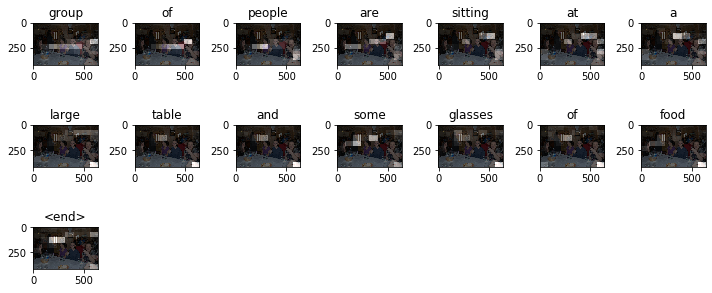

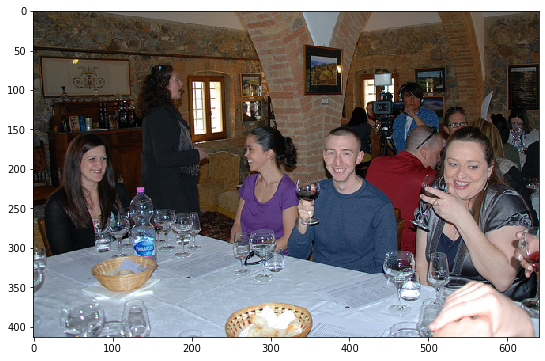

In [103]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

plt.figure(figsize=(10,6))
img = mpimg.imread(image)
plt.imshow(img)
